## Setup

In [128]:
import pandas as pd
from pathlib import Path
import statsmodels.formula.api as sm
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import (
    LassoCV,
    LinearRegression
)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    cross_val_score,
    StratifiedKFold,
    TimeSeriesSplit
)

from xgboost import XGBRegressor

import matplotlib.pyplot as plt

In [138]:
interim = '../../data/interim'
br = pd.read_pickle(Path(interim) / 'batting_records.pkl')
gl = pd.read_pickle(Path(interim) / 'game_logs.pkl')
events = pd.read_pickle(Path(interim) / 'events.pkl')
people = pd.read_pickle(Path(interim) / 'people.pkl')

## League DAta
League = events[events.BAT_FLD_CD != 1].groupby('year')[['HR', 'H', 'PA']].sum()
League.columns = ['League_HR', 'League_H', 'League_PA']
League['League_HPPA'] = (100*(League['League_H'] / League['League_PA'])).astype('float')

## Featurize

In [139]:
League = League.reset_index()

League['L1_League_HPPA'] = League['League_HPPA'].shift(1) 
League['L2_League_HPPA'] = League['League_HPPA'].shift(2)
League['L3_League_HPPA'] = League['League_HPPA'].shift(3)

League = League.dropna()

## Setup training

In [140]:
x_vars = ['L1_League_HPPA', 'L2_League_HPPA', 'L3_League_HPPA']
y_var = ['League_HPPA']

In [141]:
def gen_pipeline(clf):
    x_vars = [
        'L1_League_HPPA', 'L2_League_HPPA', 'L3_League_HPPA'
    ]
    preprocessor =  ColumnTransformer(
        [('spot', 'passthrough', x_vars)],
        remainder='drop'
    )

    fitted_model = Pipeline([
        ('select', preprocessor),
        ('poly', PolynomialFeatures(2, interaction_only=True)),
        ('scale', StandardScaler()),
        ('clf', clf),
    ])
    
    return fitted_model

## Training

In [142]:
LR = gen_pipeline(LinearRegression())
Lasso = gen_pipeline(LassoCV(cv=5, random_state=0))
XGBR = XGBRegressor(
    tree_method='hist',
    verbosity = 0,
    random_state = 0,
    max_depth = 4,
    early_stopping_rounds=5,
    n_estimators = 500,
    use_label_encoder=False,
    verbose=True,
)

XGB = gen_pipeline(XGBR)

In [166]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [164]:
# tscv = TimeSeriesSplit(test_size=2, n_splits = int(np.round(League.shape[0]/2))-10)
tscv = TimeSeriesSplit(test_size=1, n_splits = League.shape[0]-10)

Accuracy: -44698.386 (51510.824)


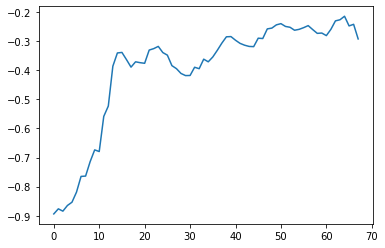

In [179]:
results = cross_val_score(LR, League[x_vars], League[y_var], cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error')
print("Accuracy: %.3f (%.3f)" % (results.mean()*1e5, results.std()*1e5))
plt.plot(np.arange(0, len(results)-20) , moving_average(results, 21))

Accuracy: -37237.425 (32329.860)


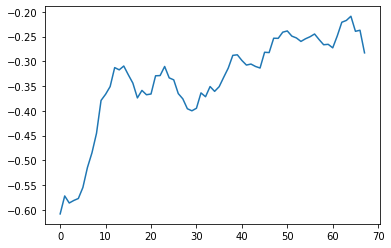

In [180]:
results = cross_val_score(Lasso, League[x_vars], League[y_var], cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error')
print("Accuracy: %.3f (%.3f)" % (results.mean()*1e5, results.std()*1e5))
plt.plot(np.arange(0, len(results)-20) , moving_average(results, 21))

Accuracy: -41265.274 (33594.274)


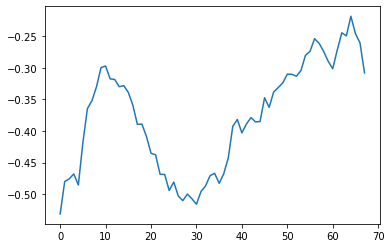

In [181]:
results = cross_val_score(XGB, League[x_vars], League[y_var], cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error')
print("Accuracy: %.3f (%.3f)" % (results.mean()*1e5, results.std()*1e5))
plt.plot(np.arange(0, len(results)-20) , moving_average(results, 21))

In [ ]:
# Plot error rate over time for the different ones to see how much they improve as data increases

In [119]:
XGB.fit(League[x_vars], League[y_var])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=5,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=1, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='hist',
             use_label_encoder=False, validate_parameters=1, verbose=True,
             verbosity=0)

## Visualize

In [24]:
# limited = merged[(merged.G >= 50)  & (merged.prev_G >= 50)]
result = sm.ols(formula="League_HPPA ~ L1_League_HPPA + L2_League_HPPA + L3_League_HPPA", data=League).fit()
print(result.summary())
coef_const = result.params[0]
coef_L1_PA = result.params[1]
coef_L2_PA = result.params[2]

                            OLS Regression Results                            
Dep. Variable:            League_HPPA   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     152.0
Date:                Tue, 30 Mar 2021   Prob (F-statistic):           6.13e-36
Time:                        14:11:35   Log-Likelihood:                 392.53
No. Observations:                  98   AIC:                            -777.1
Df Residuals:                      94   BIC:                            -766.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0184      0.010      1.

<AxesSubplot:xlabel='year', ylabel='League_HPPA'>

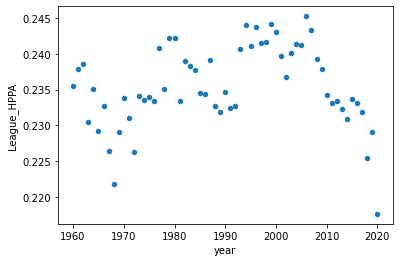

In [5]:
League[League.year >= 1960].plot.scatter('year', 'League_HPPA')